#Recomendaciones de películas utilizando Collaborative Filtering

###Estudiantes:

* Adrián Hernández Young
* René Quesada Carranza
* Marcelo Solórzano Astorga
* Kendall Tames Fernández
* Kevin Trejos Vargas





# Análisis Exploratorio de Datos (EDA, por sus siglas en inglés)

A continuación se ha de realizar un análisis exploratorio de datos, con la finalidad de mostrar las características esenciales de los datos a utilizar para el entrenamiento y validación de los distintos clasificadores a utilizar.


In [ ]:
import os

is_colab = 'google.colab' in str(get_ipython())

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/ml-100k')
else:
  data_path = os.getenv('dataPath')
  os.chdir(data_path)

Mounted at /content/drive


Se ignoran warnings que ensucian la salida.

In [ ]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

Imports para el analisis

In [ ]:
# Leer el dataset y almacenarlo en una variable con pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Barras para los datos null
import missingno as msno

Recordar primero cuales variables tenemos disponibles:

**uinfo**: Información general de los datos.

**udata**:  lista de calificaciones con el id del usuario, item_id, rating  y timestamp.
```
user_id	item_id	rating	timestamp
0	196	242	3	881250949
1	186	302	3	891717742
2	22	377	1	878887116
3	244	51	2	880606923
4	166	346	1	886397596
```

**ugenre**: lista de generos.

```
genre	genre_number
0	unknown	0
1	Action	1
2	Adventure	2
3	Animation	3
4	Children's	4
5	Comedy	5
6	Crime	6
7	Documentary	7
8	Drama	8
9	Fantasy	9
10	Film-Noir	10
11	Horror	11
12	Musical	12
13	Mystery	13
14	Romance	14
15	Sci-Fi	15
16	Thriller	16
17	War	17
18	Western	18
```
**uitem**: lista de fichas de películas. Un mismo cortometraje puede ser clasificado dentro de uno o más géneros, por lo cual además de la información general tendremos una columna para cada categoría.
```
    'movie_id',
    'movie_title',
    'release_date',
    'video_release_date',
    'IMDb_URL',
    'unknown',
    'Action',
    'Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
```
**uuser**: lista de usuarios. Alberga información asociada al perfil del usuario.
```
 user_id	age	gender	occupation	zip code
0	1	24	M	technician	85711
1	2	53	F	other	94043
2	3	23	M	writer	32067
3	4	24	M	technician	43537
4	5	33	F	other	15213
```
Vamos a incluir del dataset la lista de u.occupation que contiene la lista de ocupaciones de los usuarios, esto nos ayudara a codificar las ocupaciones en un valor numérico.

**uoccupation**: lista de ocupaciones.
```
  occupation
0	administrator
1	artist
2	doctor
3	educator
4	engineer
```

Una vez cambiado el entorno de ejecución a la carpeta donde se encuentran los datos, es posible leer el dataset.  
A continuacion la carga de los datos antes descritos

In [ ]:
udata = pd.read_csv(
    "u.data",
    sep    = '\t',                                                              # Los datos están separados por tabs
    header = None,                                                              # u.data viene sin headers
    names  = ['user_id', 'item_id', 'rating', 'timestamp']                      # Nombres de las columnas
)
udata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
uinfo = pd.read_csv(
    "u.info",
    header = None,
    names  = ['info']
)
uinfo

,info
0,943 users
1,1682 items
2,100000 ratings


In [ ]:
ugenre = pd.read_csv(
    "u.genre",
    sep = "|",
    header = None,
    names  = ['genre', 'genre_number']
)
ugenre

,genre,genre_number
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


In [ ]:
uitem = pd.read_csv(
    "u.item",
    sep      = "|",
    header   = None,
    names    = ["movie_id", "movie_title", "release_date",
                "video_release_date", "IMDb_URL", "unknown",
                "Action", "Adventure", "Animation",
                "Children's", "Comedy", "Crime", "Documentary",
                "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi",
                "Thriller", "War", "Western"],
    encoding = 'latin-1'                                                        # Requerido por carácteres inválidos en UTF-8
)
uitem.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
uuser = pd.read_csv(
    "u.user",
    sep = "|",
    header = None,
    names  = ['user_id', 'age', 'gender', 'occupation', 'zip code']
)
uuser.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
uoccupation = pd.read_csv(
    "u.occupation",
    header = None,
    names  = ['occupation']
)

uoccupation.head()

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer


## Compilando los datos

Lo primero que vamos a hacer es cargar la lista de ocupaciones y luego vamos a juntar todo

In [ ]:
# Combinando los datos de usuarios en la lista udata
user_data_merge = pd.merge(udata, uuser, on = 'user_id')
# ahora agregamos la información de las peliculas
all_merge_data = pd.merge(user_data_merge, uitem, left_on='item_id', right_on= 'movie_id')

all_merge_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip code,movie_id,movie_title,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   item_id             100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   age                 100000 non-null  int64  
 5   gender              100000 non-null  object 
 6   occupation          100000 non-null  object 
 7   zip code            100000 non-null  object 
 8   movie_id            100000 non-null  int64  
 9   movie_title         100000 non-null  object 
 10  release_date        99991 non-null   object 
 11  video_release_date  0 non-null       float64
 12  IMDb_URL            99987 non-null   object 
 13  unknown             100000 non-null  int64  
 14  Action              100000 non-null  int64  
 15  Adventure           100000 non-null

<Axes: >

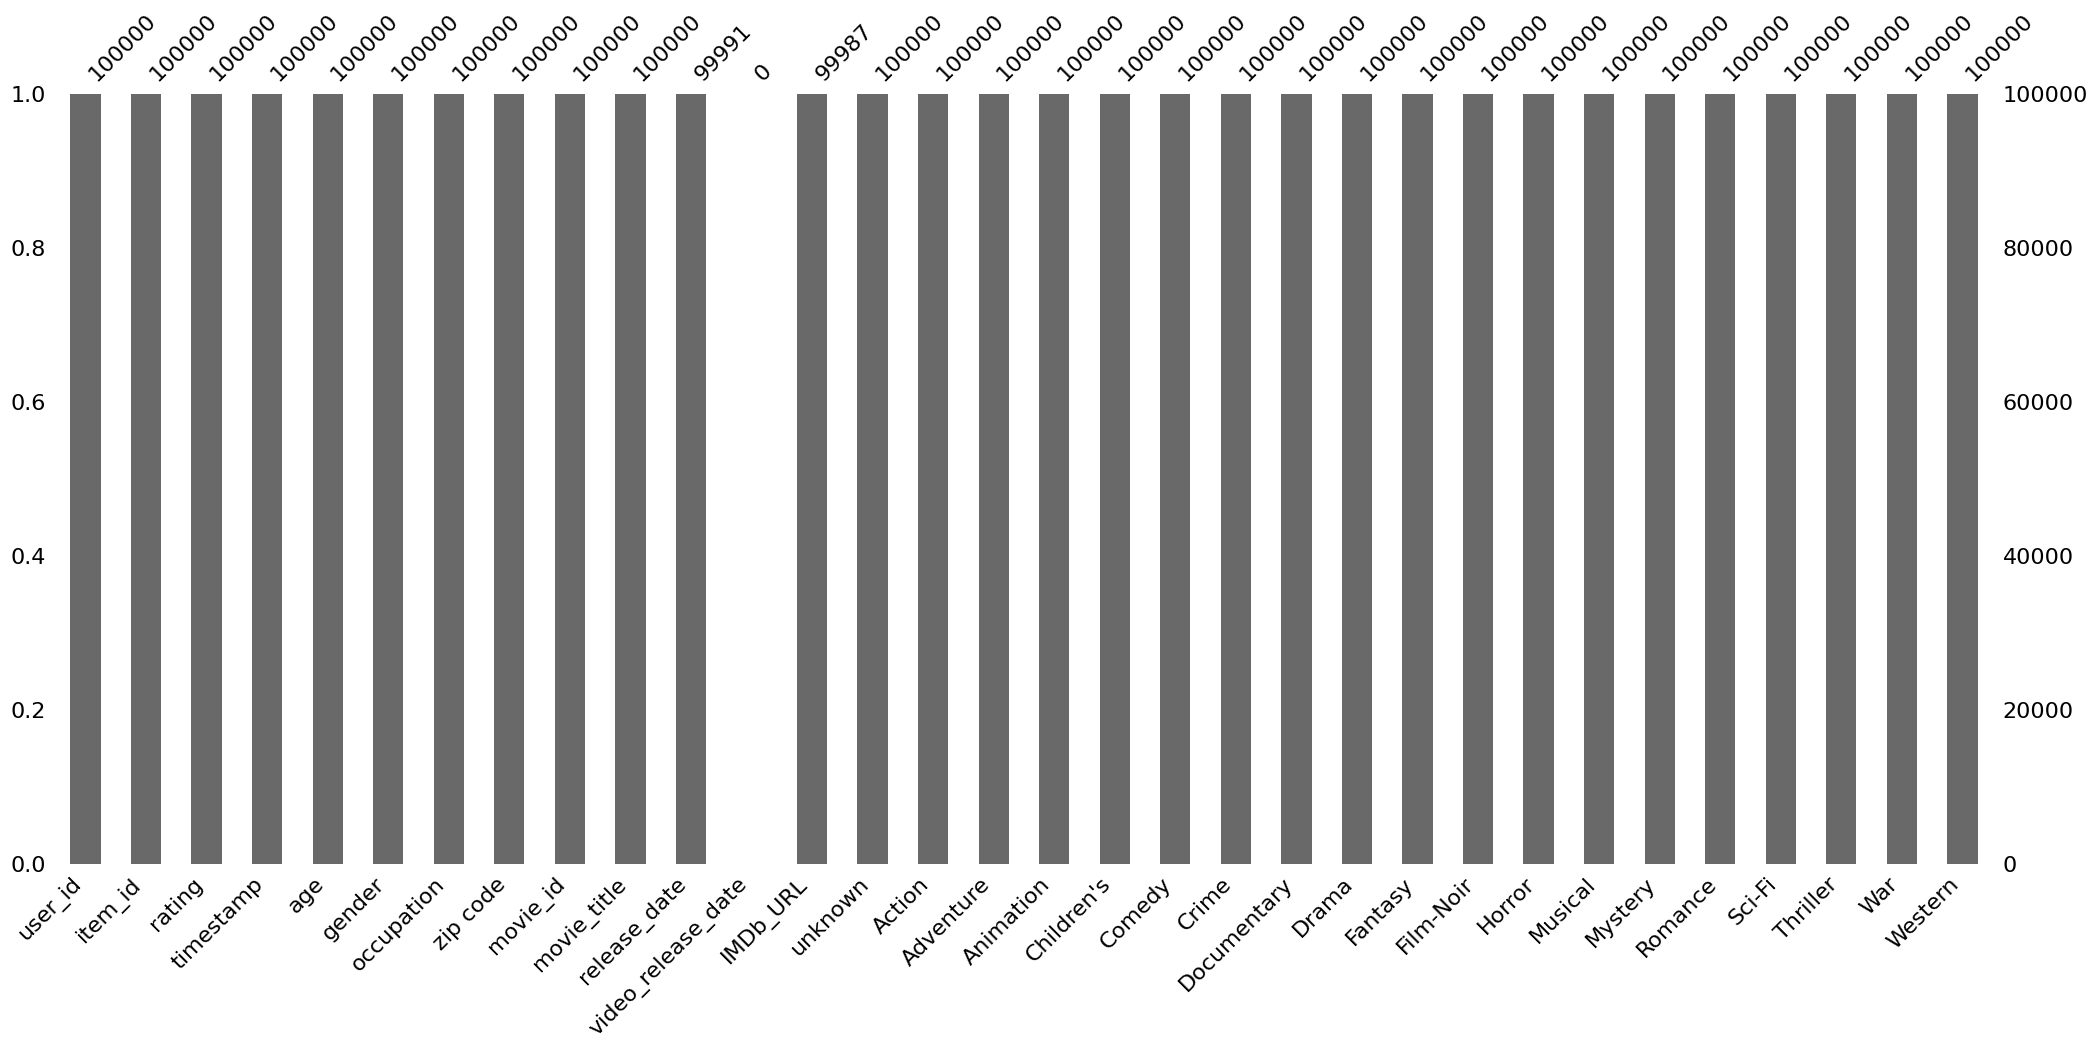

In [ ]:
all_merge_data.info()
# Ver las barras de valores vacios
msno.bar(all_merge_data)

Vemos que hay valores nulos pero tambien hay valores que no son de tipo INT por lo que primero tenemos que filtrar unos valores y eliminar las columnas que estan completamente vacias como el de video_release_date.

El primer paso es convertir los valores que no son enteros a un número, por ejemplo la fecha.

Hay muchas formas de convertir las fechas para un algoritmo uno de ellos es usar una fecha de referencia, es común usar la menor fecha en el dataset, sin embargo al tratarse de la fecha de salida de una pelicula vamos a usar como referencia la fecha de la primer pelicula que fue el 01-Nov-1895.

Ademas otros valores como el genero se pueden convertir en booleanos.

Otro punto importante es el de usar la lista de ocupaciones para codificar nuestra columna de ocupacion.

In [ ]:
# Definimos una constante de fecha de referencia
REFERENCE_DATE = pd.to_datetime('01-Nov-1895', format='%d-%b-%Y')

# Convertimos el formato de la fecha de release date a un tipo date time
all_merge_data['release_date'] = pd.to_datetime(all_merge_data['release_date'], format='%d-%b-%Y')

# Calcularmos la diferencia en dias de la fecha de cada una de las peliculas con respecto a la fecha referencia
all_merge_data['release_date_integer'] = (all_merge_data['release_date'] - REFERENCE_DATE).dt.days

# Ahora convertimos la columna de genero en una columna booleana
all_merge_data = pd.get_dummies(all_merge_data, columns=['gender'], drop_first=True)

# codificamos la columna de ocupaciones con la lista que tenemos de uoccupation
# usamos la posicion de la ocupacion en el dataset como numero para codificar
all_merge_data["occupation"] = all_merge_data["occupation"].apply(lambda x: uoccupation[uoccupation["occupation"] == x].index[0])

# Finalmente eliminamos las columnas que no ocupamos
all_merge_data.drop(columns=['release_date'], inplace=True)
all_merge_data.drop(columns=['video_release_date'], inplace=True)

all_merge_data.head()

,user_id,item_id,rating,timestamp,age,occupation,zip code,movie_id,movie_title,IMDb_URL,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_date_integer,gender_M
0,196,242,3,881250949,49,20,55105,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
1,305,242,5,886307828,23,14,94086,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
2,6,242,4,883268170,42,6,98101,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
3,234,242,4,891033261,60,15,94702,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
4,63,242,3,875747190,31,11,75240,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               100000 non-null  int64  
 1   item_id               100000 non-null  int64  
 2   rating                100000 non-null  int64  
 3   timestamp             100000 non-null  int64  
 4   age                   100000 non-null  int64  
 5   occupation            100000 non-null  int64  
 6   zip code              100000 non-null  object 
 7   movie_id              100000 non-null  int64  
 8   movie_title           100000 non-null  object 
 9   IMDb_URL              100000 non-null  object 
 10  unknown               100000 non-null  int64  
 11  Action                100000 non-null  int64  
 12  Adventure             100000 non-null  int64  
 13  Animation             100000 non-null  int64  
 14  Children's            100000 non-null  int64  
 15  C

<Axes: >

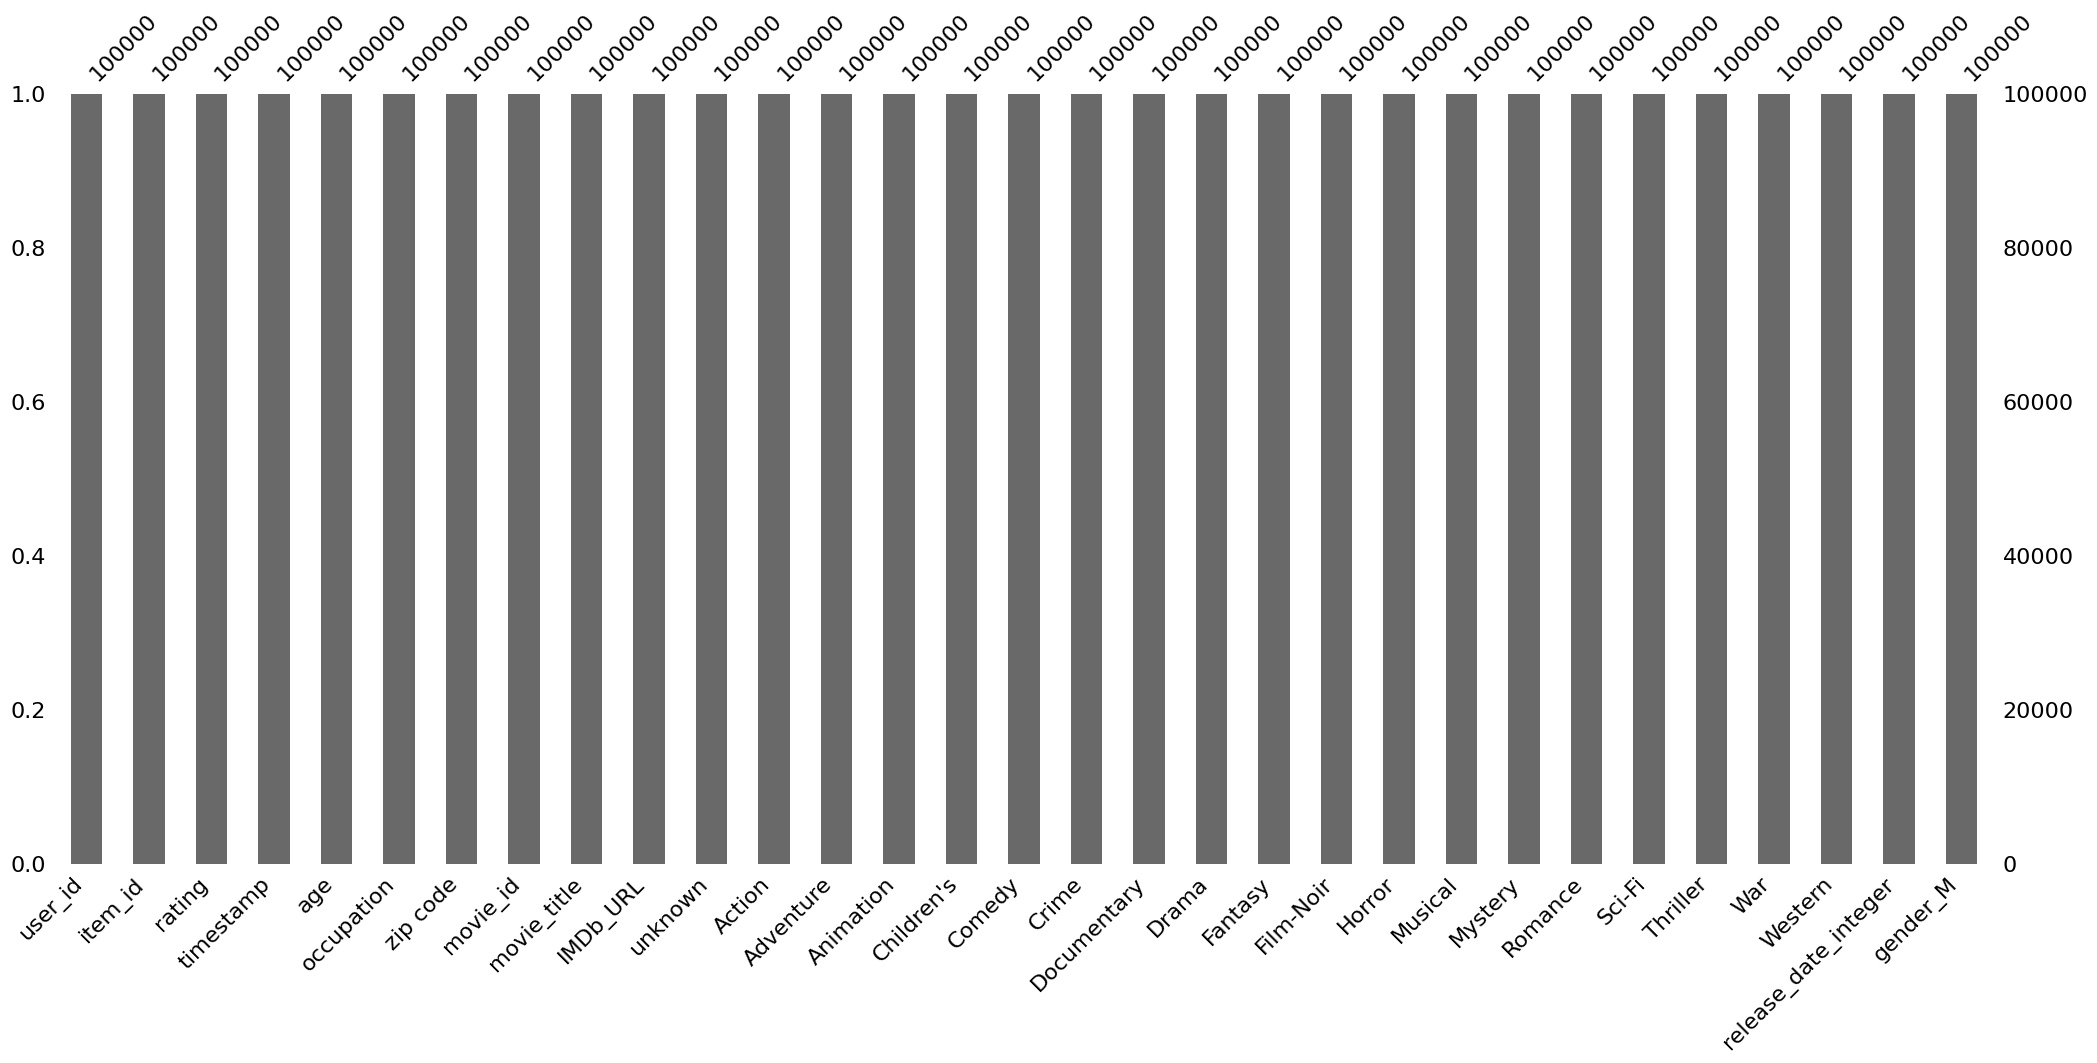

In [ ]:
# Se obtiene la media de la columna release_date_integer
mean_value = all_merge_data['release_date_integer'].mean()

# Se reemplaza los nulos con el valor de la media
all_merge_data['release_date_integer'].fillna(value=mean_value, inplace=True)

# como aun nos quedan algunas columnas on valores nulos vamos a llenarlos
all_merge_data.fillna(method='ffill', inplace=True)

# resultado final
all_merge_data.info()
# Ver las barras de valores vacios
msno.bar(all_merge_data)

## Distribución de los ratings

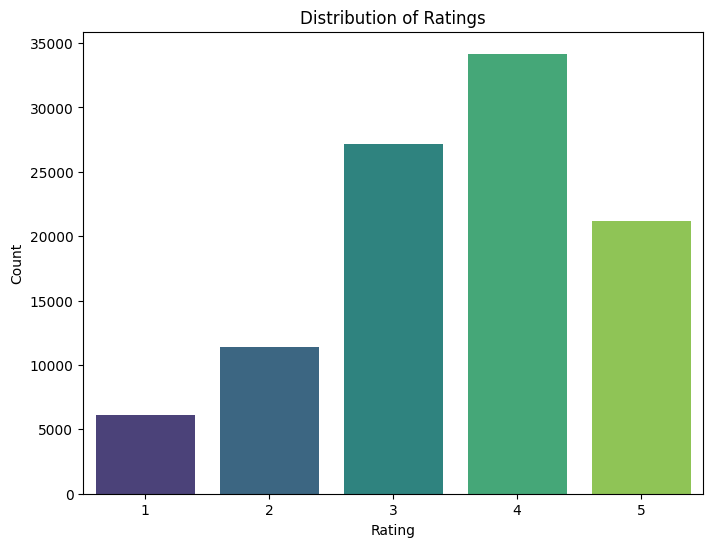

In [ ]:
# Gráfico de la distribución de las calificaiones
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=udata, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

##Distribución de la cantidad de calificaciones por usuario

Identificar la distribución de la cantidad de calificaciones por usuario es importante para saber si existen usuarios con pocas calificaciones, lo que nos podría estar generando ruido.

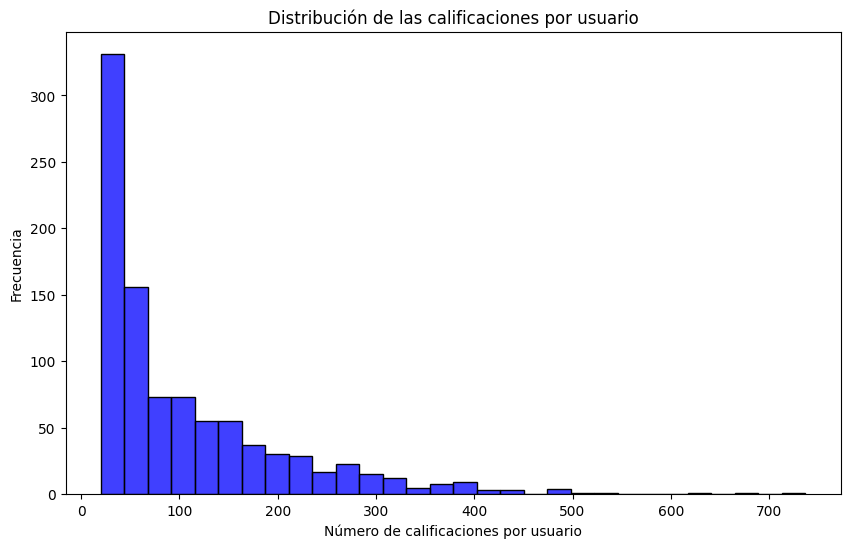

In [ ]:
# Calcular el número de calificaciones por usuario
user_ratings_count = udata.groupby('user_id').size()

# Gráfico del número de calificaciones por usuario
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=30, color='blue')
plt.title('Distribución de las calificaciones por usuario')
plt.xlabel('Número de calificaciones por usuario')
plt.ylabel('Frecuencia')
plt.show()

##Número de calificaciones por usuario

Identificar usuarios activos permite identificar qué usuarios son los más activos y cuáles son los menos activos en el sistema. Los usuarios que dan muchas calificaciones pueden tener un impacto significativo en los modelos de recomendación, ya que proporcionan más información.

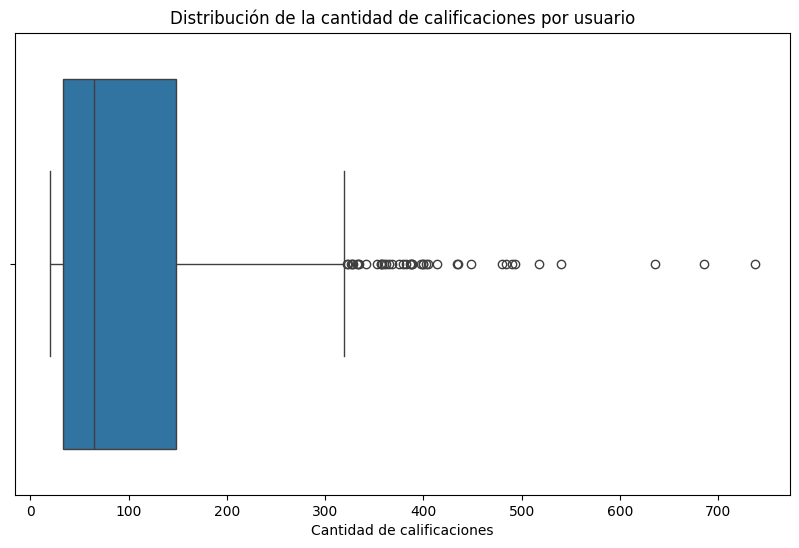

In [ ]:
ratings_per_user = udata.groupby('user_id').size()

plt.figure(figsize=(10, 6))
sns.boxplot(x=ratings_per_user)
plt.title('Distribución de la cantidad de calificaciones por usuario')
plt.xlabel('Cantidad de calificaciones')
plt.show()

##Número de Calificaciones por Película

Identificar películas populares permite identificar cuáles son las películas más populares o más vistas, es decir, las que han recibido más calificaciones. Estas películas pueden ser cruciales en los sistemas de recomendación y análisis de tendencias.

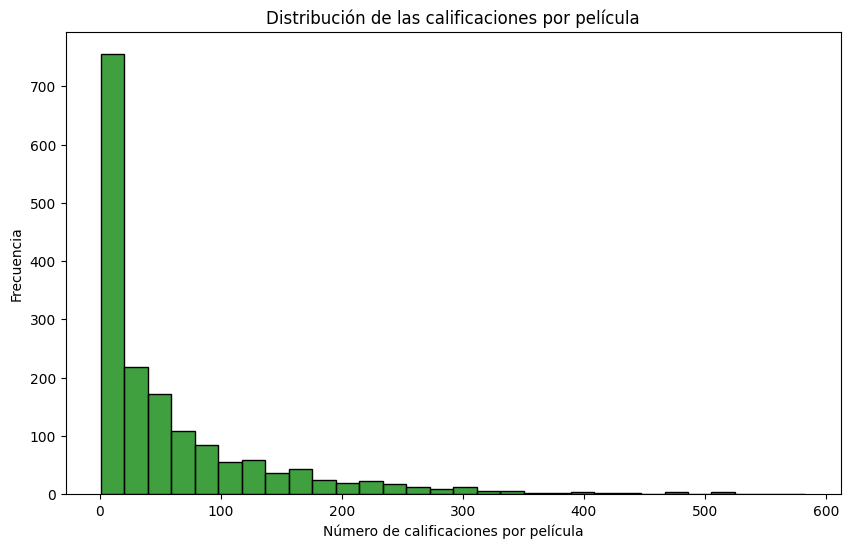

In [ ]:
# Calcular el número de calificaciones por película
movie_ratings_count = udata.groupby('item_id').size()

# Gráfico del número de calificaciones por película
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings_count, bins=30, color='green')
plt.title('Distribución de las calificaciones por película')
plt.xlabel('Número de calificaciones por película')
plt.ylabel('Frecuencia')
plt.show()


##Promedio de calificaciones por usuario

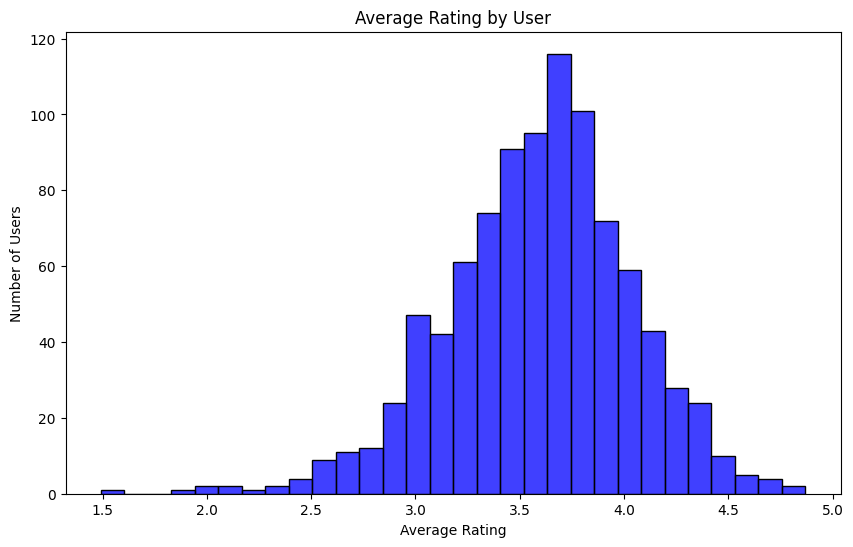

In [ ]:
average_ratings_per_user = udata.groupby('user_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings_per_user, bins=30, color='blue')
plt.title('Average Rating by User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()

##Promedio de calificaciones por película

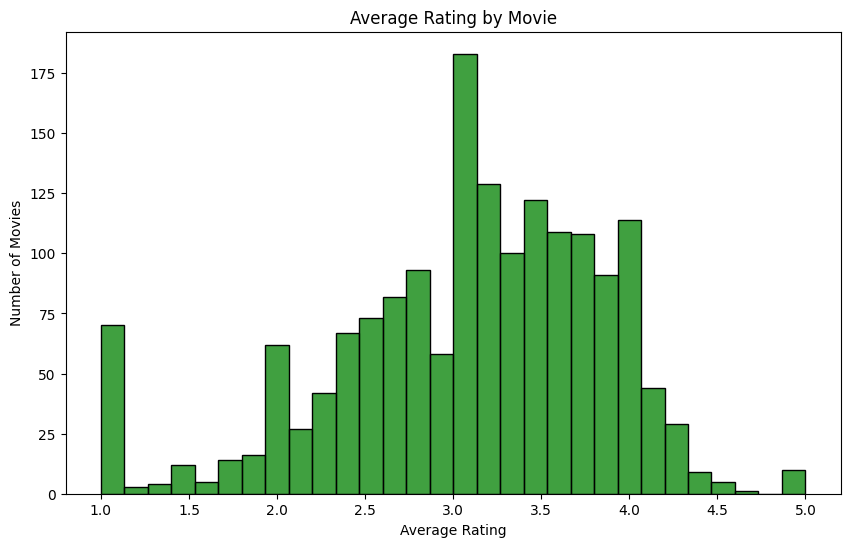

In [ ]:
average_ratings_per_item = udata.groupby('item_id')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings_per_item, bins=30, color='green')
plt.title('Average Rating by Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()

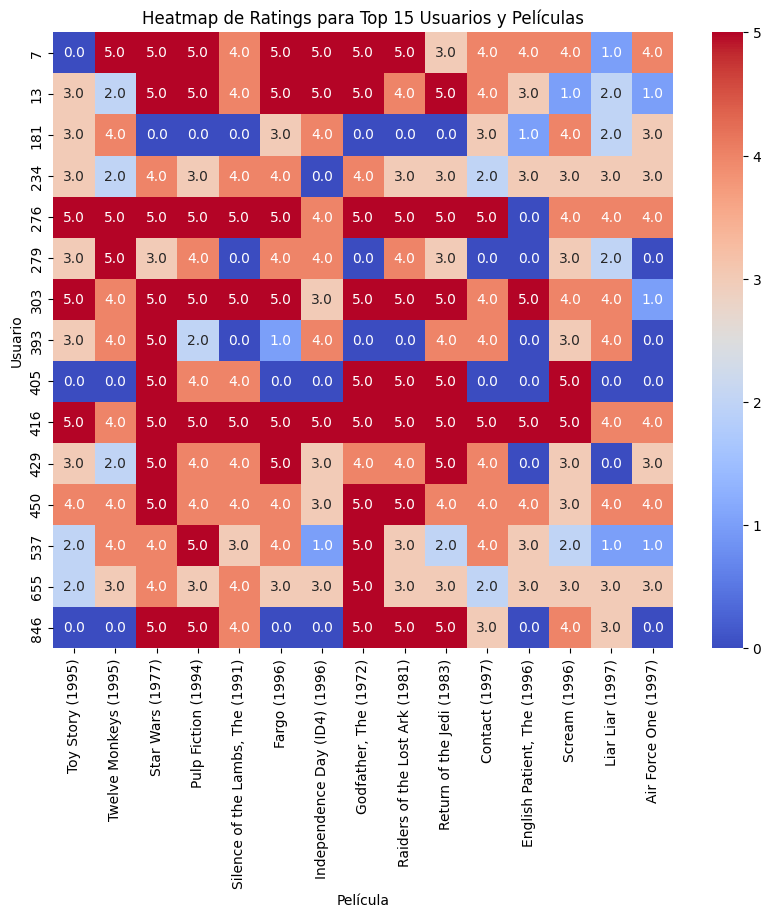

In [ ]:
# Encontrar los 10 usuarios con más ratings
top_users = udata.groupby('user_id').size().sort_values(ascending=False).head(15).index

# Encontrar los 10 items con más ratings
top_items = udata.groupby('item_id').size().sort_values(ascending=False).head(15).index

# Filtrar los datos para incluir solo los top 10 usuarios y items
filtered_data = udata[udata['user_id'].isin(top_users) & udata['item_id'].isin(top_items)]

# Crear una tabla pivote para el heatmap
heatmap_data = filtered_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Reemplazar item_id por movie_title
item_to_title = uitem.set_index('movie_id')['movie_title'].to_dict()
heatmap_data.columns = [item_to_title.get(item, item) for item in heatmap_data.columns]

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Heatmap de Ratings para Top 15 Usuarios y Películas')
plt.xlabel('Película')
plt.ylabel('Usuario')
plt.show()


## Datos de un usuario Ejemplo
Para la siguiente seccion vemos los datos para el usuario 63 el cual se tomo como ejemplo para las recomendacion (el codigo se realizo con la ayuda del LLM de google gemini)

In [ ]:
# Filter for user_id 63 and sort by rating in descending order
user_63_ratings = all_merge_data[all_merge_data['user_id'] == 63].sort_values(by='rating', ascending=False)

# Get the top 10 movies
top_10_movies = user_63_ratings[['movie_title', 'rating']].head(40)

print(top_10_movies)


                                             movie_title  rating
11786                                       Fargo (1996)       5
89268                       Celluloid Closet, The (1995)       5
94443                             Beautiful Thing (1996)       5
4353                            Cold Comfort Farm (1995)       5
6869                           Fifth Element, The (1997)       5
4753                          Waiting for Guffman (1996)       5
43856                                    In & Out (1997)       5
43042                    My Best Friend's Wedding (1997)       4
89020                                    Swingers (1996)       4
19817                         Mission: Impossible (1996)       4
29400     Mystery Science Theater 3000: The Movie (1996)       4
78941                                        Emma (1996)       4
39361                 People vs. Larry Flynt, The (1996)       4
40919                               Trainspotting (1996)       4
33326                    

## Datasets final

In [ ]:
#dataset con todos las columnas
all_merge_data


,user_id,item_id,rating,timestamp,age,occupation,zip code,movie_id,movie_title,IMDb_URL,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_date_integer,gender_M
0,196,242,3,881250949,49,20,55105,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
1,305,242,5,886307828,23,14,94086,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
2,6,242,4,883268170,42,6,98101,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
3,234,242,4,891033261,60,15,94702,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
4,63,242,3,875747190,31,11,75240,242,Kolya (1996),http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,36974.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,3,889289491,17,18,60089,1679,B. Monkey (1998),http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,...,0,0,0,1,0,1,0,0,37352.0,True
99996,863,1678,1,889289570,17,18,60089,1678,Mat' i syn (1997),http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,...,0,0,0,0,0,0,0,0,37352.0,True
99997,863,1680,2,889289570,17,18,60089,1680,Sliding Doors (1998),http://us.imdb.com/Title?Sliding+Doors+(1998),...,0,0,0,1,0,0,0,0,37316.0,True
99998,896,1681,3,887160722,28,20,91505,1681,You So Crazy (1994),http://us.imdb.com/M/title-exact?You%20So%20Cr...,...,0,0,0,0,0,0,0,0,35855.0,True


In [ ]:
#dataset con solo ratings y peliculas
movies = all_merge_data[['item_id', 'movie_title']].copy()
# itemid movietilte
#  0     'Indiana Jones'

ratings = all_merge_data[['user_id', 'item_id', 'rating']].copy()
# Userid itemid ratings
#  0      0      4       (usuario 0 leda un rating de 4 a indiana jones)

#acomodo las columna para que en lugar de que sea user_id o item_id sean userid, itemid
ratings.rename(columns={'user_id': 'userid', 'item_id': 'itemid'}, inplace=True)
movies.rename(columns={'item_id': 'itemid'}, inplace=True)

In [ ]:
from scipy.sparse import csr_matrix
def ratings_matrix(ratings):
    return csr_matrix(pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=np.average).fillna(0).values)

#Matriz densa de ratings
dense_matrix = ratings_matrix(ratings)

#ejemplo de como se ve
print(np.array(dense_matrix))

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  :	:
  (942, 738)	4.0
  (942, 755)	2.0
  (942, 762)	4.0
  (942, 764)	3.0
  (942, 784)	2.0
  (942, 793)	3.0
  (942, 795)	3.0
  (942, 807)	4.0
  (942, 815)	4.0
  (942, 823)	4.0
  (942, 824)	3.0
  (942, 830)	2.0
  (942, 839)	4.0
  (942, 927)	5.0
  (942, 940)	1.0
  (942, 942)	5.0
  (942, 1010)	2.0
  (942, 1027)	2.0
  (942, 1043)	3.0
  (942, 1046)	2.0
  (942, 1066)	2.0
  (942, 1073)	4.0
  (942, 1187)	3.0
  (942, 1227)	3.0
  (942, 1329)	3.0


In [ ]:
# lista de features
feature_list = all_merge_data.drop(columns=['rating','movie_id','movie_title','zip code','IMDb_URL'], axis=1).columns
#feature_list = all_merge_data.drop(columns=['rating','movie_id','movie_title','zip code','IMDb_URL'], axis=1).columns
# creamos el vector X y y para la creacion del arbol, algunas columnas no se ocuparan como el zip code, la ocupacion o el IMDb_URL
X = pd.get_dummies(all_merge_data[feature_list])

# nuestra columna objetivo es el de rating
y = all_merge_data.rating

# Definiciones y objetos a usar

## Definiciones comunes para el dataset
Definiciones usadas por todo los modelos relacionadas con el dataset


In [ ]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

class Helper:
    @staticmethod
    def get_examples(dataframe, labels_column="rating"):
        """
        Obtiene ejemplos y etiquetas de un DataFrame.

        Args:
          dataframe: DataFrame que contiene las calificaciones, con las columnas 'userid' y 'itemid'.
          labels_column: Nombre de la columna que contiene las etiquetas (por defecto, "rating").

        Returns:
          examples: Arreglo con los pares de identificadores de usuario e ítem.
          labels: Arreglo con las etiquetas correspondientes a los ejemplos.
        """
        examples = dataframe[['userid', 'itemid']].values
        labels = dataframe[f'{labels_column}'].values
        return examples, labels

    @staticmethod
    def train_test_split(examples, labels, test_size=0.1, verbose=0):
        """
        Divide los datos en conjuntos de entrenamiento y prueba.

        Args:
          examples: Arreglo de ejemplos a dividir.
          labels: Arreglo de etiquetas correspondientes a los ejemplos.
          test_size: Proporción de datos que se utilizará para pruebas (por defecto, 0.1).
          verbose: Nivel de detalle de los mensajes de salida (por defecto, 0).

        Returns:
          x_train, x_test: Conjuntos de ejemplos de entrenamiento y prueba.
          y_train, y_test: Conjuntos de etiquetas de entrenamiento y prueba.
        """
        if verbose:
            print("Train/Test split ")
            print(100-test_size*100, "% of training data")
            print(test_size*100, "% of testing data")

        # split data into train and test sets
        train_examples, test_examples, train_labels, test_labels = sklearn_train_test_split(
            examples,
            labels,
            test_size=test_size,
            random_state=42,
            shuffle=True
        )

        # transform train and test examples to their corresponding one-hot representations
        train_users = train_examples[:, 0]
        test_users = test_examples[:, 0]

        train_items = train_examples[:, 1]
        test_items = test_examples[:, 1]

        # Final training and test set
        x_train = np.array(list(zip(train_users, train_items)))
        x_test = np.array(list(zip(test_users, test_items)))

        y_train = train_labels
        y_test = test_labels

        if verbose:
            print()
            print('number of training examples : ', x_train.shape)
            print('number of training labels : ', y_train.shape)
            print('number of test examples : ', x_test.shape)
            print('number of test labels : ', y_test.shape)

        return (x_train, x_test), (y_train, y_test)

    @staticmethod
    def mean_ratings(dataframe):
        """
        Calcula la calificación media para cada usuario.

        Args:
          dataframe: DataFrame que contiene las calificaciones.

        Returns:
          means: DataFrame con las calificaciones medias de cada usuario.
        """
        means = dataframe.groupby(by='userid', as_index=False)['rating'].mean()
        return means

    @staticmethod
    def normalized_ratings(dataframe, norm_column="norm_rating"):
        """
        Calcula las calificaciones normalizadas restando la calificación media del usuario a cada calificación.

        Args:
          dataframe: DataFrame que contiene las calificaciones.
          norm_column: Nombre de la columna que contendrá las calificaciones normalizadas (por defecto, "norm_rating").

        Returns:
          norm: DataFrame con las calificaciones normalizadas.
        """
        mean = Helper.mean_ratings(dataframe=dataframe)
        norm = pd.merge(dataframe, mean, suffixes=('', '_mean'), on='userid')
        norm[f'{norm_column}'] = norm['rating'] - norm['rating_mean']

        return norm

    @staticmethod
    def rating_matrix(dataframe, column):
        """
        Crea una matriz de calificaciones dispersa a partir de un DataFrame.

        Args:
          dataframe: DataFrame que contiene las calificaciones.
          column: Nombre de la columna que contiene las calificaciones.

        Returns:
          matrix: Matriz dispersa de calificaciones.
        """
        crosstab = pd.crosstab(dataframe.userid, dataframe.itemid, dataframe[f'{column}'], aggfunc=np.average).fillna(0).values
        matrix = csr_matrix(crosstab)
        return matrix

    @staticmethod
    def scale_ratings(dataframe, scaled_column="scaled_rating"):
        """
        Escala las calificaciones dividiéndolas por 5.0.

        Args:
          dataframe: DataFrame que contiene las calificaciones.
          scaled_column: Nombre de la columna que contendrá las calificaciones escaladas (por defecto, "scaled_rating").

        Returns:
          dataframe: DataFrame con las calificaciones escaladas.
        """
        dataframe[f"{scaled_column}"] = dataframe.rating / 5.0
        return dataframe

    @staticmethod
    def ids_encoder(ratings):
        """
        Codifica los identificadores de usuarios e ítems en un DataFrame de calificaciones.

        Args:
          ratings: DataFrame que contiene las calificaciones, con las columnas 'userid' y 'itemid'.

        Returns:
          ratings: DataFrame con los identificadores de usuarios e ítems codificados.
          uencoder: LabelEncoder ajustado para los identificadores de usuarios.
          iencoder: LabelEncoder ajustado para los identificadores de ítems.
        """
        users = sorted(ratings['userid'].unique())
        items = sorted(ratings['itemid'].unique())

        # create users and items encoders
        uencoder = LabelEncoder()
        iencoder = LabelEncoder()

        # fit users and items ids to the corresponding encoder
        uencoder.fit(users)
        iencoder.fit(items)

        # encode userids and itemids using .loc to avoid SettingWithCopyWarning
        ratings.loc[:, 'userid'] = uencoder.transform(ratings['userid'].tolist())
        ratings.loc[:, 'itemid'] = iencoder.transform(ratings['itemid'].tolist())

        return ratings, uencoder, iencoder

## Definiciones Comunes para las metricas
Procedimientos para crear metricas y resultados y estandarizar todos los modelos

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import numpy as np

class Metrics_Class:
    def __init__(self, y_true, y_pred, model_name):
        self.y_true = y_true
        self.y_pred = y_pred
        self.model_name = model_name

    def mae(self):
        """
        Calculates the mean absolute error (MAE) between true and predicted values.

        Returns:
            None. Prints the model name and MAE.
        """
        error = metrics.mean_absolute_error(self.y_true, self.y_pred)
        print(f"{self.model_name} MAE: {error}")

    def rmse(self):
        """
        Calcula el error cuadrático medio (RMSE).

        Returns:
            El valor RMSE.
        """
        mse = mean_squared_error(self.y_true, self.y_pred)
        rmse_value = np.sqrt(mse)
        print(f"Modelo {self.model_name}\n  RMSE: {rmse_value}")
        return rmse_value

    def classification_metrics(self, verbose=True):
        """
        Calcula e imprime las métricas de clasificación: accuracy, recall y precision.

        Returns:
            None. Imprime el nombre del modelo, accuracy y el reporte de clasificación.
        """
        try:

            # Asegurarse de que las etiquetas sean valores discretos
            self.y_true = np.round(self.y_true).astype(int)
            self.y_pred = np.round(self.y_pred).astype(int)

            if verbose:
              # Verificar los datos después de la conversión
              accuracy = accuracy_score(self.y_true, self.y_pred)
              report = classification_report(self.y_true, self.y_pred)
              print(f"Modelo {self.model_name}\n")
              print(f"  Accuracy: {accuracy}")
              print(f"  Reporte de Clasificación:\n{report}")
            return classification_report(self.y_true, self.y_pred, output_dict=True)
        except ValueError as e:
            print(f"Error al calcular métricas de clasificación: {e}")

# Ejemplo de uso
# y_true = [valores verdaderos]
# y_pred = [valores predichos]
# model_name = "Nombre del Modelo"

# metrics = Metrics_Class(y_true, y_pred, "nombre modelo")
# metrics.mae()
# metrics.rmse()
# metrics.classification_metrics()

# Clases para los filtros  
Cada desarrollador debera crear una clase para cada filtro lo cual ayudara a modularizar el codigo, esta clase debera contener los siguiente:

``` python
class EJEMPLO:

    def __init__(self, ratings, movies, k=20, metric='adjusted_cosine'):

        # En esta clase se inicializa con lo que el desarrollador quiera, en este caso usa como entrada el df ratings,el df de peliculas,k y metrica a usar para el knn
        #aqui hacemos los calculos para entrenar al modelo y demas
        # pueden usar la clase Helper para algunos calculos
        self.ratings, self.uencoder, self.iencoder = Helper.ids_encoder(ratings)
   
    # este es un def obligatorio debe de contener el userid y el numero de top a imprimir
    def topn_recommendation(self, userid, n=30):
        """
        Produce top-N recommendation for a given user
        :param userid : user for which we produce top-N recommendation
        :param n : length of the top-N recommendation list
        :return topN
        """
        user_rated_items, candidates = self.candidate_items(userid)
        ranked_candidates = self.rank_candidates(candidates, user_rated_items)
        topn = pd.DataFrame(ranked_candidates[:n], columns=['itemid', 'similarity_with_Iu'])
        topn = pd.merge(topn, self.movies, on='itemid', how='inner')
        return topn

    
    # este es un def obligatorio debe de contener el xtext,ytest y usar la clase Metrics_Class para imprimir
    def evaluate(self, x_test, y_test, verbose=True):
        #este paso deberia realizarlo con el predict de su modelo
        preds = list(self.predict(u, i) for (u, i) in x_test)
        
        #esto es lo mismo para todos
        metrics_class= Metrics_Class(y_test, preds, "Item to Item knn")
        if verbose:
          metrics_class.mae()
          metrics_class.rmse()
        metrics_class.classification_metrics(verbose)
  
  ```

Cada clase puede hacer importaciones necesarios, esto hace que tengamos duplicaciones de importaciones pero ayuda a modularizar el trabajo

## Primer Modelo
UsertoUser

El siguiente codigo fue basado en la siguiente referencia https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/2.User-basedCollaborativeFiltering.ipynb

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from datetime import datetime
from glob import glob
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import os


class UserToUser:

    def __init__(self, ratings, movies, k=20, metric='cosine'):
        if metric not in ['cosine', 'euclidean']:
            raise Exception('UnknownSimilarityMetric : The similarity metric must be selected among '
                            'the followings : cosine, euclidean. You choosed {}'.format(metric))

        # Codificación de IDs de usuarios e items
        self.ratings, self.uencoder, self.iencoder = Helper.ids_encoder(ratings)

        # Normalización
        self.means, self.ratings = self.prepare_ratings()

        # Creación de la matriz de calificaciones
        self.ratings_matrix = self.create_ratings_matrix()

        # Parámetros del modelo
        self.k = k
        self.metric = metric

        # Inicialización del modelo de similitud
        self.model = self.init_similarity_model()

        # Cálculo de similitudes y vecinos más cercanos
        self.similarities, self.neighbors = self.compute_nearest_neighbors()

         # Datos de películas
        self.movies = movies

        self.np_ratings = self.ratings.to_numpy()

        # DataFrame para almacenar predicciones
        self.predictions = pd.DataFrame(columns=['userid', 'itemid', 'predicted_rating'])

        print('User to user recommendation model created with success ...')

    def create_ratings_matrix(self):
        """
          Crea una matriz dispersa de calificaciones a partir del DataFrame de calificaciones.

          Returns:
              matrix: Matriz dispersa de calificaciones.
          """
        return csr_matrix(
            pd.crosstab(self.ratings.userid, self.ratings.itemid, self.ratings.rating, aggfunc=np.average).fillna(0).values
        )

    def init_similarity_model(self):
        """
        Inicializa el modelo de similitud basado en vecinos más cercanos.

        Returns:
            model: Modelo de vecinos más cercanos.
        """
        print('Initialize the similarity model ...')
        model = NearestNeighbors(metric=self.metric, n_neighbors=self.k+1, algorithm='brute')
        model.fit(self.ratings_matrix)
        return model

    def prepare_ratings(self):
        """
        Normaliza las calificaciones de los usuarios y calcula las calificaciones medias.

        Returns:
            means: Array de calificaciones medias de los usuarios.
            means_ratings: DataFrame con las calificaciones normalizadas.
        """
        print('Normalize users ratings ...')
        means = self.ratings.groupby(by='userid', as_index=False)['rating'].mean()
        means_ratings = pd.merge(self.ratings, means, suffixes=('', '_mean'), on='userid')
        means_ratings['norm_rating'] = means_ratings['rating'] - means_ratings['rating_mean']

        return means.to_numpy()[:, 1], means_ratings

    def get_user_nearest_neighbors(self, userid):
        """
        Obtiene los vecinos más cercanos de un usuario específico.

        Args:
            userid: ID del usuario.

        Returns:
            similarities: Similitudes de los vecinos.
            neighbors: Vecinos más cercanos.
        """
        return self.similarities[userid], self.neighbors[userid]

    def compute_nearest_neighbors(self):
        """
        Calcula los vecinos más cercanos para todos los usuarios.

        Returns:
            similarities: Array de similitudes de los vecinos.
            neighbors: Array de vecinos más cercanos.
        """
        print('Compute nearest neighbors ...')
        similarities, neighbors = self.model.kneighbors(self.ratings_matrix)
        return similarities[:, 1:], neighbors[:, 1:]

    def user_rated_items(self, userid):
        """
        Obtiene los items calificados por un usuario específico.

        Args:
            userid: ID del usuario.

        Returns:
            items: Array de items calificados por el usuario.
        """
        activities = self.np_ratings[self.np_ratings[:, 0] == userid]
        items = activities[:, 1]
        return items

    def find_user_candidate_items(self, userid, n=50):
        """
        Encuentra items candidatos para un usuario específico.

        Args:
            userid: ID del usuario.
            n: Número de items candidatos a encontrar.

        Returns:
            candidates_items: Array de items candidatos.
        """
        user_neighbors = self.neighbors[userid]
        user_rated_items = self.user_rated_items(userid)

        neighbors_rated_items = self.ratings.loc[self.ratings.userid.isin(user_neighbors)]

        items_frequencies = neighbors_rated_items.groupby('itemid')['rating']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)

        neighbors_rated_items_sorted_by_frequency = items_frequencies.itemid
        candidates_items = np.setdiff1d(neighbors_rated_items_sorted_by_frequency, user_rated_items, assume_unique=True)

        return candidates_items[:n]

    def similar_users_who_rated_this_item(self, userid, itemid):
        """
        Encuentra usuarios similares que calificaron un item específico.

        Args:
            userid: ID del usuario objetivo.
            itemid: ID del item objetivo.

        Returns:
            users_who_rated_this_item: Array de usuarios que calificaron el item.
            sim_users_who_rated_this_item: Array de usuarios similares que calificaron el item.
        """
        users_who_rated_this_item = self.np_ratings[self.np_ratings[:, 1] == itemid][:, 0]
        sim_users_who_rated_this_item = \
            users_who_rated_this_item[np.isin(users_who_rated_this_item, self.neighbors[userid])]
        return users_who_rated_this_item, sim_users_who_rated_this_item

    def predict(self, userid, itemid):
        """
        Predice la calificación que un usuario daría a un item específico.

        Args:
            userid: ID del usuario.
            itemid: ID del ítem.

        Returns:
            r_hat: Calificación predicha del usuario al ítem.
        """
        user_mean = self.means[userid]

        user_similarities = self.similarities[userid]
        user_neighbors = self.neighbors[userid]

        iratings = self.np_ratings[self.np_ratings[:, 1].astype('int') == itemid]

        suri = iratings[np.isin(iratings[:, 0], user_neighbors)]

        normalized_ratings = suri[:, 4]
        indexes = [np.where(user_neighbors == uid)[0][0] for uid in suri[:, 0].astype('int')]
        sims = user_similarities[indexes]

        num = np.dot(normalized_ratings, sims)
        den = np.sum(np.abs(sims))

        if num == 0 or den == 0:
            return user_mean

        r_hat = user_mean + np.dot(normalized_ratings, sims) / np.sum(np.abs(sims))

        return r_hat

    def evaluate(self, x_test, y_test, verbose=True):
        """
        Evalúa el modelo User-to-User KNN utilizando métricas de rendimiento.

        Args:
            x_test: Conjunto de ejemplos de prueba (userid, itemid).
            y_test: Conjunto de etiquetas de prueba (ratings).

        Returns:
            None
        """
        preds = [self.predict(u, i) for (u, i) in x_test]

        y_test_rounded = [round(y) for y in y_test]
        preds_rounded = [round(p) for p in preds]

        y_test_clipped = [min(max(y, 1), 5) for y in y_test_rounded]
        preds_clipped = [min(max(p, 1), 5) for p in preds_rounded]

        metrics_class = Metrics_Class(y_test_clipped, preds_clipped, "KNN User to User")
        if verbose:
          metrics_class.mae()
          metrics_class.rmse()
        return metrics_class.classification_metrics(verbose)

    def user_predictions(self, userid):
        """
        Realiza predicciones de calificación para un usuario activo en cada ítem candidato y las guarda en un DataFrame.

        Args:
            userid: ID del usuario activo.

        Returns:
            None
        """
        candidates = self.find_user_candidate_items(userid, n=30)

        predictions_list = []

        for itemid in candidates:
            r_hat = self.predict(userid, itemid)
            prediction_dict = {'userid': userid, 'itemid': itemid, 'predicted_rating': float(r_hat)}
            predictions_list.append(prediction_dict)

        self.predictions = pd.concat([self.predictions, pd.DataFrame(predictions_list)], ignore_index=True)



    def all_predictions(self):
        """
        Realiza predicciones para cada usuario en la base de datos.

        Returns:
            predictions: DataFrame con todas las predicciones.
        """
        users = self.ratings.userid.unique()

        for userid in users:
            self.user_predictions(userid)

        return self.predictions

    def topn_recommendation(self, userid, n=30):
        """
        Produce las mejores N recomendaciones para un usuario específico.

        Args:
            userid: ID del usuario para el cual queremos generar recomendaciones.
            n: Número de recomendaciones.

        Returns:
            topn: DataFrame con las mejores N recomendaciones para el usuario.
        """
        uid = self.uencoder.transform([userid])[0]

        self.user_predictions(uid)

        predictions = self.predictions[self.predictions.userid == uid]
        topn = predictions.nlargest(n, 'predicted_rating')[['itemid', 'predicted_rating']]
        topn = pd.merge(topn, self.movies, on='itemid', how='inner')
        topn = topn.drop_duplicates(subset=['itemid'], keep='first')

        return topn

    def save_tensorflow_projector_files(self, embedding_file_path, user_metadata_file_path):
        """
        Guarda los archivos necesarios para visualizar las representaciones de usuarios en TensorFlow Embedding Projector.

        Args:
            embedding_file_path: Ruta del archivo para guardar las representaciones de los usuarios.
            user_metadata_file_path: Ruta del archivo para guardar los metadatos de los usuarios.
        """
        embeddings = self.ratings_matrix.toarray()
        np.savetxt(embedding_file_path, embeddings, delimiter='\t')

        user_ids = self.ratings.userid.unique()
        user_metadata = pd.DataFrame(user_ids, columns=['userid'])
        user_metadata.to_csv(user_metadata_file_path, sep='\t', index=False, header=False)

        print(f"Archivos guardados en {embedding_file_path} y {user_metadata_file_path}.")



## Segundo Modelo

El siguiente codigo fue basado en la siguiente referencia https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/3.Item-basedCollaborativeFiltering.ipynb

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sys import stdout
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder


class ItemToItem:
    def __init__(self, ratings, movies, k=20, metric='cosine'):
        valid_metrics = ['cosine', 'euclidean', ]

        if metric not in valid_metrics:
            raise Exception('UnknownSimilarityMetric: The similarity metric must be selected among '
                            'the followings: cosine, euclidean. You chose {}'.format(metric))

        #El valor maximo de K es 50
        if k > 50:
            raise Exception('Choose a value of k that is smaller than 50. You chose {}'.format(k))
        # usamos el ids encoder para convertir los ids a numericos
        self.ratings, self.uencoder, self.iencoder = Helper.ids_encoder(ratings)

        #Obtenemos los datos normalizados
        self.means, self.ratings = self.normalize()
        self.np_ratings = self.ratings.to_numpy()

        self.ratings_matrix = self.create_ratings_matrix()

        #'inicializando los dataframes para guardar vecino y similarities'
        self.similarities_df = None
        self.neighbors_df = None

        #iniciando los parametros
        self.k = k
        self.nb_items = self.ratings.itemid.nunique()
        self.metric = metric

        #iniciamos el modelo de knn
        self.model = self.init_knn_model()
        self.similarities, self.neighbors = self.knn()

        self.movies = movies
        print('Item to item recommendation model created with success ...')

    def create_ratings_matrix(self):
        """
        Crea la matriz de calificaciones.

        Returns:
            matrix: Matriz de calificaciones esparsa (CSR).
        """
        crosstab = pd.crosstab(self.ratings.itemid, self.ratings.userid, self.ratings.norm_rating, aggfunc=sum)
        matrix = csr_matrix(crosstab.fillna(0).values)
        return matrix

    def _progress(progress):
        """
        Imprime el progreso de computacion.
        """
        stdout.write('\rComputing similarities. Progress status : %.1f%%' % (float(progress / self.nb_items) * 100.0))
        stdout.flush()

    def print_ratings(self):
        """
        Normaliza las calificaciones de los usuarios.

        Returns:
            means: Promedios de calificaciones por usuario.
            means_ratings: DataFrame con calificaciones normalizadas.
        """
        print(self.np_ratings[:5])
        print(self.ratings.head())

    def normalize(self):
        """
        Normaliza las calificaciones de los usuarios.

        Returns:
            means: Promedios de calificaciones por usuario.
            means_ratings: DataFrame con calificaciones normalizadas.
        """
        print('Normalizando las calificaciones ...')
        means = self.ratings.groupby(by='userid', as_index=False)['rating'].mean()
        means_ratings = pd.merge(self.ratings, means, suffixes=('', '_mean'), on='userid')
        means_ratings['norm_rating'] = means_ratings['rating'] - means_ratings['rating_mean']

        return means.to_numpy()[:, 1], means_ratings

    def init_knn_model(self):
        """
        Inicializa el modelo KNN para calcular similitudes.

        Returns:
            model: Modelo Nearest Neighbors (KNN) inicializado.
        """
        print('Create the similarity model ...')
        model = NearestNeighbors(metric=self.metric, n_neighbors=self.k + 1, algorithm='brute')
        model.fit(self.ratings_matrix)
        return model

    def knn(self):
        """
        Calcula los vecinos más cercanos usando el modelo KNN.

        Returns:
            similarities: Matriz de similitudes entre ítems.
            neighbors: Vecinos más cercanos para cada ítem.
        """
        print('Compute nearest neighbors ...')
        similarities, neighbors = self.model.kneighbors(self.ratings_matrix)
        return similarities[:, 1:], neighbors[:, 1:]

    @staticmethod
    def cosine(x, y):
        """
        Calcula la similitud coseno entre dos vectores.

        Args:
            x: Primer vector.
            y: Segundo vector.

        Returns:
            float: Similitud coseno entre x e y.
        """
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

    def candidate_items(self, userid):
        """
        Encuentra los ítems candidatos para un usuario dado.

        Args:
            userid: ID del usuario.

        Returns:
            user_rated_items: Lista de ítems evaluados por el usuario.
            candidates: Lista de ítems candidatos para recomendar al usuario.
        """
        # Filtra los ítems que han sido evaluados por el usuario
        user_rated_items = self.np_ratings[self.np_ratings[:, 0] == userid][:, 1] # Solo los identificadores de ítems

        # Crear un conjunto vacío para almacenar los ítems vecinos
        c = set()

        # Recorrer los ítems evaluados por el usuario
        for iid in user_rated_items:

            # Actualiza el conjunto c con los vecinos del ítem actual
            c.update(self.neighbors[int(iid)])

        # Convierte el conjunto c en una lista
        c = list(c)

        # Encuentra los ítems que están en c pero no han sido evaluados por el usuario
        candidates = np.setdiff1d(c, user_rated_items, assume_unique=True)

        # Retorna los ítems evaluados y los candidatos
        return user_rated_items, candidates

    def similarity_with_i_u(self, c, user_rated_items):
        """
        Calcula la similitud entre un ítem candidato y los ítems evaluados por un usuario.

        Args:
            c: Ítem candidato.
            user_rated_items: Lista de ítems evaluados por el usuario.

        Returns:
            w: Similitud acumulada entre el ítem candidato y los ítems evaluados.
        """
        w = 0
        for iid in user_rated_items:
            if c in self.neighbors[int(iid)]:
                w = w + self.similarities[int(iid), self.neighbors[int(iid)] == c][0]
        return w

    def rank_candidates(self, candidates, user_rated_items):
        """
        Ordena los ítems candidatos según su similitud acumulada con los ítems evaluados por el usuario.

        Args:
            candidates (list): Lista de ítems candidatos.
            user_rated_items (numpy.ndarray): Array de ítems evaluados por el usuario.

        Returns:
            list: Lista de ítems candidatos ordenados por similitud acumulada descendente.
        """
        sims = [self.similarity_with_i_u(c, user_rated_items) for c in candidates]
        candidates = self.iencoder.inverse_transform(candidates)
        mapping = list(zip(candidates, sims))
        ranked_candidates = sorted(mapping, key=lambda couple: couple[1], reverse=True)
        return ranked_candidates

    def list_recommendation(self, userid):
        """
        Genera las mejores recomendaciones para un usuario dado.

        Args:
            userid (int): ID del usuario para el cual se generan las recomendaciones.
            n (int, optional): Número máximo de recomendaciones a devolver. Por defecto es 30.

        Returns:
            pandas.DataFrame: DataFrame con las mejores n recomendaciones para el usuario,
                              incluyendo 'itemid', 'similarity_with_Iu' y datos de películas.
        """
        user_rated_items, candidates = self.candidate_items(userid)
        ranked_candidates = self.rank_candidates(candidates, user_rated_items)

        # Convertir a DataFrame y renombrar columnas
        #topn = pd.DataFrame(ranked_candidates[:n], columns=['itemid', 'similarity_with_Iu'])
        topn = pd.DataFrame(ranked_candidates, columns=['itemid', 'similarity_with_Iu'])
        topn = pd.merge(topn, self.movies, on='itemid', how='inner')

        topn = topn.drop_duplicates(subset=['itemid'], keep='first')
        return topn

    def predict(self, userid, itemid):
        """
        Predice la calificación que un usuario daría a un ítem específico.

        Args:
            userid (int): ID del usuario.
            itemid (int): ID del ítem para el cual se quiere hacer la predicción.

        Returns:
            float: Calificación predicha para el ítem por el usuario.
        """
        user_ratings = self.np_ratings[self.np_ratings[:, 0].astype('int') == userid]
        siru = user_ratings[np.isin(user_ratings[:, 1], self.neighbors[itemid])]
        scores = siru[:, 2]
        indexes = [np.where(self.neighbors[itemid] == iid)[0][0] for iid in siru[:, 1].astype('int')]
        sims = self.similarities[itemid, indexes]

        #El numerador es el producto punto de los ratings por las similitudes
        numerator = np.dot(scores, sims)

        #El denominador es la suma absolutas de las similitudes
        denominator = np.sum(np.abs(sims))

        if denominator == 0:
            return self.means[userid]

        r_hat = numerator / denominator
        return r_hat

    def topn_recommendation(self, userid, topnumber=30, threshold_similarity=15):
        """
        Genera predicciones para las mejores recomendaciones de un usuario dado.

        Args:
            userid (int): ID del usuario para el cual se generan las predicciones.
            topnumber (int, opcional): Número máximo de recomendaciones a devolver (por defecto: 30).
            threshold_similarity (int, opcional): Umbral de similitud para filtrar las recomendaciones iniciales.
                                                  Solo se incluyen las recomendaciones con similitud superior a este valor.

        Returns:
            pandas.DataFrame: DataFrame con las mejores recomendaciones para el usuario,
                              incluyendo 'itemid', 'similarity_with_Iu' y 'prediction'.
                              Las recomendaciones están ordenadas por 'similarity_with_Iu' en orden descendente.
        """
        # Obtener las mejores recomendaciones iniciales para el usuario
        topn = self.list_recommendation(userid)

        # Filtrar las recomendaciones iniciales por similitud utilizando el umbral
        topn = topn[topn['similarity_with_Iu'] > threshold_similarity]

        # Si no hay recomendaciones que superen el umbral, retornar un DataFrame vacío
        if topn.empty:
            return pd.DataFrame()

        # Obtener los itemids de las mejores recomendaciones
        itemids = topn.itemid.to_list()

        # Calcular las predicciones para cada itemid
        predictions = [(itemid, self.predict(userid, itemid)) for itemid in itemids]

        # Crear un DataFrame con las predicciones
        predictions_df = pd.DataFrame(predictions, columns=['itemid', 'predicted_rating'])

        # Combinar las recomendaciones iniciales con las predicciones
        topn_predict = pd.merge(topn, predictions_df, on='itemid', how='inner')

        # Ordenar las recomendaciones por prediccion y 'similarity_with_Iu' en orden descendente
        topn_predict = topn_predict.sort_values(by=['predicted_rating', 'similarity_with_Iu'], ascending=[False, False])

        # Tomar las primeras topnumber recomendaciones
        topn_predict = topn_predict.head(topnumber)

        return topn_predict


    def evaluate(self, x_test, y_test, verbose=True):
        """
        Evalúa el modelo Item-to-Item KNN utilizando métricas de rendimiento.

        Args:
            x_test (list of tuples): Lista de tuplas (userid, itemid) para evaluación.
            y_test (list): Lista de calificaciones verdaderas correspondientes a x_test.

        Returns:
            None
        """
        # Generar predicciones para cada par (userid, itemid) en x_test
        preds = [self.predict(u, i) for (u, i) in x_test]

        # Iniciar una instancia de la clase Metrics_Class para calcular métricas
        metrics_class = Metrics_Class(y_test, preds, "Item to Item knn")

        if verbose:
          # Calcular el Error Absoluto Medio (MAE)
          metrics_class.mae()

          # Calcular la Raíz del Error Cuadrático Medio (RMSE)
          metrics_class.rmse()

        # Calcular métricas de clasificación (si aplican para el contexto del modelo)
        return metrics_class.classification_metrics(verbose)


    def save_tensorflow_projector_files(self, embedding_file_path, item_metadata_file_path, user_metadata_file_path):
        """
        Genera archivos para el Projector de TensorFlow.

        Args:
            embedding_file_path (str): Ruta del archivo para guardar los embeddings.
            item_metadata_file_path (str): Ruta del archivo para guardar los metadatos de los ítems.
            user_metadata_file_path (str): Ruta del archivo para guardar los metadatos de los usuarios.
        """
        # Asegurarse de que las similitudes y vecinos estén calculados
        if self.ratings_matrix is None:
            raise ValueError("La matriz de calificaciones no está calculada. Ejecuta primero el método adecuado.")

        # Extraer los embeddings de la matriz de calificaciones
        embeddings = self.ratings_matrix.toarray()
        np.savetxt(embedding_file_path, embeddings, delimiter='\t')

        # Guardar los metadatos de los ítems (utilizando el nombre de las películas como ejemplo)
        item_metadata = self.movies.itemid.unique()
        item_metadata = self.movies[['itemid', 'movie_title']]
        item_metadata.to_csv(item_metadata_file_path, sep='\t', index=False, header=False)

        # Crear metadatos de usuarios
        user_ids = self.ratings.userid.unique()
        user_metadata = pd.DataFrame(user_ids, columns=['userid'])
        user_metadata.to_csv(user_metadata_file_path, sep='\t', index=False, header=False)

        print(f"Archivos guardados en: \n Embeddings: {embedding_file_path} \n Item Metadata: {item_metadata_file_path} \n User Metadata: {user_metadata_file_path}")


## Tercer Modelo

Promedios

In [ ]:
class SimpleAverageRecommender:

    def __init__(self, ratings, movies):
        self.ratings = ratings
        # Calculate the average rating for each movie
        self.average_ratings = \
            self.ratings.groupby('itemid')['rating'].mean().to_dict()
        self.movies = movies.drop_duplicates(subset='itemid')

    def predict(self, user_id, item_id):
        # Return the average rating for the item
        return self.average_ratings.get(item_id, 0)                             # Default to 0 if the item_id is not found


    # Returns the top N recommendations for a specific user
    def topn_recommendation(self, userid, n = 30):
        # Get all items the user has already rated
        user_rated_items = set(
            self.ratings[self.ratings['userid'] == userid]['itemid']
        )

        # Create a list of movies that the user hasn't rated yet
        unrated_movies = []
        unrated_movies = set([
            (item_id, self.average_ratings[item_id])
            for item_id in self.average_ratings
            if item_id not in user_rated_items
        ])

        # Sort the unrated movies by their average rating in descending order
        unrated_movies = sorted(
            unrated_movies, key = lambda x: x[1],
            reverse = True
        )

        # Get the top n recommendations
        topn_items = unrated_movies[0:n]

        # Create a DataFrame for the top n recommendations
        topn_recommendations = \
            pd.DataFrame(topn_items, columns = ['itemid', 'predicted_rating'])
        topn_recommendations = \
            pd.merge(topn_recommendations, self.movies, on = 'itemid')

        return topn_recommendations


    # Evaluates the recommendation method
    def evaluate(self, x_test, y_test, verbose=True):
        predictions = []
        for user_id, item_id in x_test:
            predictions.append(self.predict(user_id, item_id))

        # Convert to numpy arrays for easier manipulation
        predictions = np.array(predictions)
        y_test = np.array(y_test)

        # Create an instance of Metrics_Class and calculate metrics
        metrics_class = Metrics_Class(
            y_test,
            predictions,
            "Simple Average Recommender"
        )
        if verbose:
          metrics_class.mae()
          metrics_class.rmse()
        return metrics_class.classification_metrics(verbose)

## Cuarto Modelo

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357241 sha256=6e6193a49eb9443a8a660c552a098a07c1233242f577fde3f83778832abe527e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Reader
from surprise import Dataset
from collections import defaultdict
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

In [ ]:
class SurpriseSVDRecommender:

    def __init__(self, ratings, movies, factors, epochs, lr=0.005, reg=0.02, state=42, test_size=.10):
        """
        Inicializa el recomendador utilizando SVD de Surprise.

        Args:
            ratings (DataFrame): DataFrame de ratings con columnas ['userid', 'itemid', 'rating'].
            movies (DataFrame): DataFrame de películas con columnas ['itemid', 'movie_title'].
            factors (int): Número de factores latentes en el modelo SVD.
            epochs (int): Número de épocas de entrenamiento.
            lr (float): Tasa de aprendizaje para SGD.
            reg (float): Parámetro de regularización.
            state (int): Semilla para la aleatoriedad.
            test_size (float): Proporción de datos para el conjunto de prueba.
        """
        self.ratings = ratings
        self.movies = movies.drop_duplicates(subset='itemid') # Asegura que no haya duplicados en los datos de películas

        # Crea el objeto Reader y el Dataset a partir del DataFrame de ratings
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(ratings[["userid", "itemid", "rating"]], reader)

        # Divide el Dataset en conjuntos de entrenamiento y prueba
        self.trainset, self.testset = surprise_train_test_split(data, test_size)

        # Inicializa el algoritmo SVD con los parámetros proporcionados
        self.svd = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr, reg_all=reg, random_state=state)

        # Entrena el modelo SVD en el conjunto de entrenamiento
        self.svd.fit(self.trainset)

    # Retorna las top-N recomendaciones para un usuario específico
    def topn_recommendation(self, userid, n = 10):
      # Obtiene una lista de todos los IDs de películas en el dataset
      movie_ids = self.ratings["itemid"].unique()

      # Obtiene una lista de todos los IDs de películas que el usuario ha visto
      movie_ids_user = self.ratings.loc[self.ratings["userid"] == userid, "itemid"]
      # Obtiene una lista de todos los IDs de películas que el usuario no ha visto
      movie_ids_to_pred = np.setdiff1d(movie_ids, movie_ids_user)

      # Aplica una calificación de 4 a todas las interacciones (solo como placeholder para el formato de Surprise)
      test_set = [[userid, movie_id, 4] for movie_id in movie_ids_to_pred]

      # Predice las calificaciones y genera recomendaciones
      predictions = self.svd.test(test_set)
      pred_ratings = np.array([pred.est for pred in predictions])

      print("Top {0} películas recomendadas para el usuario {1}:".format(n, userid))

      # Clasifica las top-N películas basadas en las calificaciones predichas
      index_max = (-pred_ratings).argsort()[:n]

      # Crea un DataFrame para almacenar los resultados
      recommendations = pd.DataFrame(columns=['itemid', 'title', 'predicted_rating'])

      for i in index_max:
          movie_id = movie_ids_to_pred[i]
          movie_title = self.movies[self.movies["itemid"] == movie_id]["movie_title"].values[0]
          predicted_rating = pred_ratings[i]
          recommendations = pd.concat([recommendations, pd.DataFrame({
              'itemid': [movie_id],
              'title': [movie_title],
              'predicted_rating': [predicted_rating]
          })], ignore_index=True)

      # Ordena las recomendaciones por calificación predicha en orden descendente
      recommendations.sort_values(by='predicted_rating', ascending=False, inplace=True)

      # Restablece el índice del DataFrame
      recommendations.reset_index(drop=True, inplace=True)

      return recommendations

    # Calcula e imprime RMSE, MAE y el reporte de clasificación.
    def evaluate(self, x_test_ignored, y_test_ignored, verbose=True):
        # Predice las calificaciones para el conjunto de prueba
        predictions = self.svd.test(self.testset)

        # Calcula e imprime RMSE y MAE
        if verbose:
          rmse = accuracy.rmse(predictions)
          mae = accuracy.mae(predictions)

        # Prepara las calificaciones verdaderas y predichas para las métricas de clasificación
        true_ratings = [pred.r_ui for pred in predictions]
        pred_ratings = [pred.est for pred in predictions]

        # Redondea las calificaciones verdaderas y predichas al entero más cercano
        true_ratings = np.round(true_ratings).astype(int)
        pred_ratings = np.round(pred_ratings).astype(int)

        if verbose:
          print("\nReporte de Clasificación:")
          print(classification_report(true_ratings, pred_ratings))
        return classification_report(true_ratings, pred_ratings, output_dict=True)

    def predict(self, userid, itemid):
        """
        Predice la calificación para un usuario y un ítem específico.

        Args:
            userid (int): ID del usuario.
            itemid (int): ID del ítem.

        Returns:
            float: Calificación predicha.
        """
        return self.svd.predict(userid, itemid).est

# Recomendaciones Finales

In [ ]:
# prepare data
ratings, uencoder, iencoder = Helper.ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = Helper.get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = Helper.train_test_split(examples=raw_examples, labels=raw_labels)


## Primer Modelo

In [ ]:
usertouser = UserToUser(ratings, movies, metric='euclidean')
_ = usertouser.evaluate(x_test, y_test)


Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
KNN User to User MAE: 0.7616
Modelo KNN User to User
  RMSE: 1.0560303025955269
Modelo KNN User to User

  Accuracy: 0.3929
  Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.45      0.12      0.19       619
           2       0.24      0.14      0.18      1145
           3       0.36      0.47      0.41      2691
           4       0.41      0.55      0.47      3366
           5       0.53      0.26      0.34      2179

    accuracy                           0.39     10000
   macro avg       0.40      0.31      0.32     10000
weighted avg       0.40      0.39      0.38     10000



In [ ]:
usertouser.topn_recommendation(63,5)

,itemid,predicted_rating,movie_title
0,482,4.341968,Some Like It Hot (1959)
128,204,4.331471,Back to the Future (1985)
478,192,4.204494,Raging Bull (1980)
594,179,4.122933,"Clockwork Orange, A (1971)"
815,249,4.111361,Austin Powers: International Man of Mystery (1...


In [ ]:
usertouser = UserToUser(ratings, movies, metric='cosine')
_ = usertouser.evaluate(x_test, y_test)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
KNN User to User MAE: 0.7099
Modelo KNN User to User
  RMSE: 1.0071246198956711
Modelo KNN User to User

  Accuracy: 0.4243
  Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.61      0.14      0.23       619
           2       0.29      0.17      0.22      1145
           3       0.39      0.44      0.41      2691
           4       0.42      0.62      0.50      3366
           5       0.57      0.31      0.41      2179

    accuracy                           0.42     10000
   macro avg       0.46      0.34      0.35     10000
weighted avg       0.44      0.42      0.41     10000



In [ ]:
usertouser.topn_recommendation(63,5)

,itemid,predicted_rating,movie_title
0,482,4.470210,Some Like It Hot (1959)
128,356,4.459695,"Client, The (1994)"
225,203,4.122466,Unforgiven (1992)
407,473,4.066067,James and the Giant Peach (1996)
533,199,4.045655,"Bridge on the River Kwai, The (1957)"


In [ ]:
usertouser.save_tensorflow_projector_files('user_embeddings2.tsv', 'user_metadata2.tsv')

Archivos guardados en user_embeddings2.tsv y user_metadata2.tsv.


In [ ]:
if is_colab:
  from google.colab import files
  files.download('user_embeddings2.tsv')
  files.download('user_metadata2.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Segundo Modelo

In [ ]:
print("==========================")
itemtoitem = ItemToItem(ratings, movies,k=20, metric='cosine')
_ = itemtoitem.evaluate(x_test, y_test)


Normalizando las calificaciones ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Item to Item knn MAE: 0.6428502587842931
Modelo Item to Item knn
  RMSE: 0.8506683039137161
Modelo Item to Item knn

  Accuracy: 0.4743
  Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.61      0.37      0.46       619
           2       0.37      0.29      0.33      1145
           3       0.45      0.44      0.45      2691
           4       0.45      0.61      0.52      3366
           5       0.59      0.44      0.50      2179

    accuracy                           0.47     10000
   macro avg       0.50      0.43      0.45     10000
weighted avg       0.48      0.47      0.47     10000



In [ ]:
itemtoitem.topn_recommendation(63,5,1)

,itemid,similarity_with_Iu,movie_title,predicted_rating
207,60,1.687739,Three Colors: Blue (1993),5.000000
244,528,1.642778,"Killing Fields, The (1984)",5.000000
203,507,1.691179,"Streetcar Named Desire, A (1951)",4.596046
9,179,10.531178,"Clockwork Orange, A (1971)",4.555224
175,518,2.177081,Miller's Crossing (1990),4.529950


In [ ]:
embedding_file_path = 'embeddings.tsv'
item_metadata_file_path = 'item_metadata.tsv'
user_metadata_file_path = 'user_metadata.tsv'

itemtoitem.save_tensorflow_projector_files(embedding_file_path, item_metadata_file_path, user_metadata_file_path)

Archivos guardados en: 
 Embeddings: embeddings.tsv 
 Item Metadata: item_metadata.tsv 
 User Metadata: user_metadata.tsv


In [ ]:
print("==========================")
itemtoitem = ItemToItem(ratings, movies,k=20, metric='euclidean')
_ = itemtoitem.evaluate(x_test, y_test)

Normalizando las calificaciones ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...
Item to Item knn MAE: 0.6961561106293939
Modelo Item to Item knn
  RMSE: 0.9101975650293974
Modelo Item to Item knn

  Accuracy: 0.4385
  Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.76      0.27      0.40       619
           2       0.47      0.17      0.25      1145
           3       0.40      0.55      0.46      2691
           4       0.42      0.63      0.50      3366
           5       0.76      0.18      0.29      2179

    accuracy                           0.44     10000
   macro avg       0.56      0.36      0.38     10000
weighted avg       0.51      0.44      0.41     10000



## Tercer modelo

In [ ]:
#print("==========================")
averagerecommender = SimpleAverageRecommender(ratings, movies)
averagerecommender.evaluate(x_test, y_test)
averagerecommender.topn_recommendation(63, 20)


Simple Average Recommender MAE: 0.8048704533164638
Modelo Simple Average Recommender
  RMSE: 1.0022154413386541
Modelo Simple Average Recommender

  Accuracy: 0.3693
  Reporte de Clasificación:
              precision    recall  f1-score   support

           1       1.00      0.03      0.05       619
           2       0.25      0.09      0.13      1145
           3       0.34      0.50      0.41      2691
           4       0.39      0.66      0.49      3366
           5       1.00      0.00      0.00      2179

    accuracy                           0.37     10000
   macro avg       0.60      0.26      0.22     10000
weighted avg       0.53      0.37      0.29     10000



,itemid,predicted_rating,movie_title
0,813,5.000000,"Celluloid Closet, The (1995)"
1,1292,5.000000,"Simple Wish, A (1997)"
2,1188,5.000000,Young Guns II (1990)
3,1598,5.000000,City of Industry (1997)
4,1466,5.000000,Margaret's Museum (1995)
5,1652,5.000000,Temptress Moon (Feng Yue) (1996)
6,1499,5.000000,Grosse Fatigue (1994)
7,1535,5.000000,"Enfer, L' (1994)"
8,1121,5.000000,"Umbrellas of Cherbourg, The (Parapluies de Che..."
9,1200,5.000000,Kim (1950)


## Cuarto modelo

In [ ]:
param_execute_grid = False # @param {type:"boolean"}
if param_execute_grid:
  reader = Reader(rating_scale=(1, 5))
  data = Dataset.load_from_df(ratings[["userid", "itemid", "rating"]], reader)

  param_grid = {
      "n_factors": [20, 40, 50, 100],  # Default 100
      "n_epochs": [5, 10, 20],  # Default 20
      "lr_all": [0.005, 0.025, 0.125],  # Default 0.005
      "reg_all": [0.02, 0.08, 0.16, 0.32],  # Default 0.02
      "random_state": [42],
  }

  grid_search = GridSearchCV(
      SVD,
      param_grid,
      measures=["rmse", "mae"],
      cv=10,
      n_jobs=-1,
      joblib_verbose=2
  )

  grid_search.fit(data)

  print(grid_search.best_score['rmse'])
  print(grid_search.best_params['rmse'])

In [ ]:
svdRecommender = SurpriseSVDRecommender(ratings, movies, 100, 20, 0.025, 0.08, 42)
svdRecommender.evaluate(x_test, y_test)
svdRecommender.topn_recommendation(63, 10)

RMSE: 0.9053
MAE:  0.7142

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.75      0.05      0.09       593
           2       0.34      0.17      0.23      1167
           3       0.40      0.55      0.46      2730
           4       0.43      0.66      0.52      3342
           5       0.76      0.15      0.25      2168

    accuracy                           0.43     10000
   macro avg       0.54      0.32      0.31     10000
weighted avg       0.50      0.43      0.39     10000

Top 10 películas recomendadas para el usuario 63:


,itemid,title,predicted_rating
0,1448,My Favorite Season (1993),4.477115
1,168,Monty Python and the Holy Grail (1974),4.354954
2,407,Spy Hard (1996),4.347461
3,113,"Horseman on the Roof, The (Hussard sur le toit...",4.240960
4,473,James and the Giant Peach (1996),4.232116
5,356,"Client, The (1994)",4.205216
6,222,Star Trek: First Contact (1996),4.188831
7,640,"Cook the Thief His Wife & Her Lover, The (1989)",4.180679
8,301,In & Out (1997),4.177852
9,1366,JLG/JLG - autoportrait de décembre (1994),4.157325


# Merge de los modelos para hacer predicciones

Una vez se tiene los modelos entrenados, se puede crear un sistema que es capaz de recomendar items basado en una métrica que retornará un __número de 0 a 1__. Para esto, se crea una clase wrapper con una instancia de cada modelo. Cada vez que se intente predecir un item, se eligirá la clase que retorne la mejor métrica.

In [ ]:
class ModelConditionalWrapper:
  def __init__(self, label, trained_model, score_function):
    """
    Inicializa el contenedor de modelos

    Args:
      trained_model: Modelo entrenado
      score_function: Función que recibe el modelo en cuestión, un usuario y un item y devuelve la métrica a comparar
    """
    self.label = label
    self.trained_model = trained_model
    self.score_function = score_function

  def prediction_score(self, userid, itemid):
    return self.score_function(self.trained_model, userid, itemid)

  def predict(self, userid, itemid):
    return self.trained_model.predict(userid, itemid)

Con esta clase que abstrae los modelos, es posible crear entonces una clase final que se encargará de encontrar el mejor modelo para predecir un item para un usuario en específico.

In [ ]:
import concurrent.futures
from tqdm import tqdm
import threading

class RecommenderSystem:
  def __init__(self, modelWrappers):
    self.modelWrappers = modelWrappers

  def predict(self, userid, itemid, verbose=True):
    scores = [modelWrapper.prediction_score(userid, itemid) for modelWrapper in self.modelWrappers]
    best_model = self.modelWrappers[np.argmax(scores)]
    if verbose:
      print(f"Best model: {best_model.label}")
    return best_model.predict(userid, itemid)

  def evaluate(self, x_test, y_test, verbose=True):
        def predict_wrapper(args):
            user_id, item_id = args
            return self.predict(user_id, item_id, verbose=False)

        if verbose:
            print("Iniciando predicciones")

        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(predict_wrapper, x_test), total=len(x_test), desc="Prediciendo"))

        predictions = np.array(results)
        y_test = np.array(y_test)

        # Create an instance of Metrics_Class and calculate metrics
        metrics_class = Metrics_Class(
            y_test,
            predictions,
            "Recommender System"
        )

        if verbose:
            print("\n")
            metrics_class.mae()
            metrics_class.rmse()

        return metrics_class.classification_metrics(verbose)

  # Obtiene las mejores recomendaciones utilizando los modelos
  def topn_recommendation(self, userid, topnumber=30):

    # Multiplica el rating que predijo un modelo por el score de la predicción
    def get_movie_score(recommendation, wrapper):
      return recommendation['predicted_rating'] * wrapper.prediction_score(userid, recommendation['itemid'])

    # Obtiene los ratings con peso de todas las predicciones
    def get_weighted_ratings(wrapper):
       recommended_df = wrapper.trained_model.topn_recommendation(userid, topnumber)
       recommended_df['weighted_rating'] = recommended_df.apply(lambda recommendation: get_movie_score(recommendation, wrapper), axis=1)
       return recommended_df[['itemid', 'predicted_rating', 'weighted_rating']]

    # Se encuentran todos los ratings en forma concurrente
    with concurrent.futures.ThreadPoolExecutor() as executor:
      weighted_ratings = executor.map(get_weighted_ratings, self.modelWrappers)

    # Se ordenan los ratings, se eliminan los duplicados, y se retornan los primeros [topnumber]
    recommendations_df = pd.concat(weighted_ratings).sort_values(by='weighted_rating', ascending=False)
    return recommendations_df.drop_duplicates(subset=['itemid'], keep='first').head(topnumber)


## Definición de condicionales para cada modelo

Se consideró que varios modelos podrían funcionar mejor con usuarios que posean cierta cantidad mínima de valoraciones. En caso de que no se cumpla, se piensa retornar la salida generada por el modelo por defecto, que es el de recomendación por promedio.

In [ ]:
user_ratings_threshold = 10

Adicionalmente, se definirá un score mínimo que debe retornar el modelo evaluado, en su defecto, se eligirá el modelo por promedio.

In [ ]:
min_model_score = 0.2

Se consideró que un método efectivo para considerar la validez de la aplicación de uno u otro modelo es utilizar su métrica de F1-Score. Sin embargo, hay modelos que proporcionan más información que puede ser utilizada para ajustar este score dependiendo del usuario o del item a evaluar. Esto se explica en las siguientes funciones.

In [ ]:
# Para modelos que no ofrecen matriz de similitud, simplemmente se retorna el F1-Score
def f1_score(model):
  report = model.evaluate(x_test, y_test, verbose=False)
  return report['weighted avg']['f1-score']

In [ ]:
# Para modelos que sí ofrecen matriz de similitud
def weighted_f1_score(model, index_id):
  # Se obtiene el F1 score
  report = model.evaluate(x_test, y_test, verbose=False)
  f1_score = report['weighted avg']['f1-score']

  # Se obtiene la máxima similitud
  max_similarity = np.max(model.similarities[index_id])

  # Se normaliza la similitud, de forma que vaya de 0.5 a 1.5
  normalized_similarity = max_similarity + 0.5

  # Se retorna el F1 score multiplicado por la similitud normalizada, poniendo como limites 0 y 1
  return np.clip(f1_score * normalized_similarity, 0, 1)


### Primer modelo

In [ ]:
class UserToUserScoreCache:
  def __init__(self):
    self.cache = {}
    self.lock = threading.Lock()

  def get_score(self, model, userid, itemid):
    with self.lock:
      if userid not in self.cache:
        self.cache[userid] = weighted_f1_score(model, userid)
    return self.cache[userid]

user_to_user_score_cache = UserToUserScoreCache()
usertouser_conditional = ModelConditionalWrapper('User to user', usertouser, user_to_user_score_cache.get_score)

### Segundo modelo

In [ ]:
class ItemToItemScoreCache:
  def __init__(self):
    self.cache = {}
    self.lock = threading.Lock()

  def get_score(self, model, userid, itemid):
    with self.lock:
      if itemid not in self.cache:
        self.cache[itemid] = weighted_f1_score(model, itemid)
    return self.cache[itemid]

item_to_item_score_cache = ItemToItemScoreCache()

itemtoitem_conditional = ModelConditionalWrapper('Item to item', itemtoitem, item_to_item_score_cache.get_score)

### Tercer modelo

In [ ]:
class AverageScoreCache:
  def __init__(self):
    self.cache = {}
    self.lock = threading.Lock()

  def get_score(self, model, userid, itemid):
    with self.lock:
      if userid not in self.cache:
        self.cache[userid] = 1 if len(model.ratings.groupby('userid').get_group(userid)) < user_ratings_threshold else min_model_score
    return self.cache[userid]

average_score_cache = AverageScoreCache()

averagerecommender_conditional = ModelConditionalWrapper('Average', averagerecommender, average_score_cache.get_score)

### Cuarto modelo

In [ ]:
class SvdScoreCache:
  def __init__(self):
    self.cache = None
    self.lock = threading.Lock()

  def get_score(self, model, userid, itemid):
    with self.lock:
      if self.cache is None:
        self.cache = f1_score(model)
    return self.cache

svd_score_cache = SvdScoreCache()

svdrecommender_conditional = ModelConditionalWrapper('SVD', svdRecommender, svd_score_cache.get_score)

## Construcción de objeto predictor

In [ ]:
recommender_system = RecommenderSystem(
    [
        usertouser_conditional,
        itemtoitem_conditional,
        averagerecommender_conditional,
        svdrecommender_conditional
        ]
    )

In [ ]:
np.argmin(list(map(lambda x: np.max(x), usertouser.similarities)))

221

In [ ]:
recommender_system.predict(40, 63, verbose=True)

Best model: Item to item


3.769230769230769

In [ ]:
recommender_system.predict(40, 1545, verbose=True)

Best model: User to user


3.769230769230769

In [ ]:
recommender_system.predict(221, 1545, verbose=True)

Best model: SVD


2.8171829718078474

Por último, la evaluación es la siguiente:

In [ ]:
param_execute_recommender_evaluate = False # @param {type:"boolean"}
if param_execute_recommender_evaluate:
  _ = recommender_system.evaluate(x_test, y_test)

In [ ]:
recommender_system.topn_recommendation(63, 30)

Top 30 películas recomendadas para el usuario 63:


,itemid,predicted_rating,weighted_rating
29,1466,3.585000,3.585000
1,1553,3.585000,3.585000
26,444,3.585000,3.585000
14,953,3.585000,3.585000
5,813,3.585000,3.554972
6,1188,3.585000,3.534107
18,1628,3.585000,3.189575
9,1484,3.585000,2.905165
21,1598,3.585000,2.841587
23,1079,3.585000,2.763942


# Referencias  
Codigo usado como referencia:  
https://colab.research.google.com/github/nzhinusoftcm/review-on-collaborative-filtering/blob/master/2.User-basedCollaborativeFiltering.ipynb#scrollTo=zPzoV2kAeagQ  
https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/README.md  

Regression usada en knn:  
https://medium.com/@nialloulton/understanding-the-r-hat-statistic-d83b3b5ca162  

Gemini y chatGPT para generacion de codigo fue usado durante el EDA de los nuevos graficos

Tambien se reutilizo codigo del proyecto 2